The test dataset underwent the same cleaning and preprocessing pipeline as the training customer dataset to ensure full compatibility for model inference. Because the test file contains customer-level demographic fields only (and no transaction or product-change data), only demographic-related transformations were applied.

In [1]:
#Deleting any previous kaggle.json file
!rm -rf ~/.kaggle


In [2]:
#Uploading the real kaggle.json file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
#Moving it to the correct location with proper permissions
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
#Verifying your credentials
!kaggle datasets list -s santander


ref                                                                title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
rymnikski/dataset-for-collaborative-filters                        Dataset for collaborative filters                     9500633  2016-12-22 21:20:13.100000           2382         37  0.8235294        
alvarolopez/tusbic                                                 Tusbic Santander                                      2832011  2018-03-21 17:52:51.343000            373         15  0.8235294        
lakshmi25npathi/santander-customer-transaction-prediction-dataset  Santander Customer Transaction Prediction Dataset   261798898  2019-05-24 06:17:57.770000           3901         51  0.588235

In [5]:
# Downloading data directly in Colab
!kaggle competitions download -c santander-product-recommendation
!unzip santander-product-recommendation.zip

 90% 206M/228M [00:00<00:00, 717MB/s] 
100% 228M/228M [00:00<00:00, 650MB/s]
Archive:  santander-product-recommendation.zip
  inflating: sample_submission.csv.zip  
  inflating: test_ver2.csv.zip       
  inflating: train_ver2.csv.zip      


In [6]:
#Unzipping the inner CSV files
!unzip -o train_ver2.csv.zip
!unzip -o test_ver2.csv.zip
!unzip -o sample_submission.csv.zip


Archive:  train_ver2.csv.zip
  inflating: train_ver2.csv          All

Archive:  test_ver2.csv.zip
  inflating: test_ver2.csv           
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [7]:
#Verifying that the files exist
!ls -lh


total 2.8G
-rw-r--r-- 1 root root   70 Dec  1 22:06 kaggle.json
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
-rw-r--r-- 1 root root  23M May 31  2018 sample_submission.csv
-rw-r--r-- 1 root root 2.3M Dec 11  2019 sample_submission.csv.zip
-rw-r--r-- 1 root root 229M Dec 11  2019 santander-product-recommendation.zip
-rw-r--r-- 1 root root 106M Oct 27  2016 test_ver2.csv
-rw-r--r-- 1 root root  13M Dec 11  2019 test_ver2.csv.zip
-rwxrwxrwx 1 root root 2.2G Oct 27  2016 train_ver2.csv
-rw-r--r-- 1 root root 215M Dec 11  2019 train_ver2.csv.zip


In [8]:
import pandas as pd
import sqlite3

# Connect (or create) SQLite test DB
conn = sqlite3.connect("santandertest.db")

# IMPORTANT: remove old test table if it exists
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS santander_test")
conn.commit()
print("✓ Dropped existing santander_test table (if it existed)\n")

# Path to test dataset
test_csv_path = "test_ver2.csv"

# Load test dataset
df_test = pd.read_csv(test_csv_path)


# Your renaming dictionary (assuming this is defined elsewhere or will be defined before this cell runs)
column_rename_dict = {
    'fecha_dato': 'transaction_date',
    'ncodpers': 'customer_id',
    'ind_empleado': 'employment_status',
    'pais_residencia': 'residence_country',
    'sexo': 'gender',
    'age': 'age',
    'fecha_alta': 'first_join_date',
    'ind_nuevo': 'is_new_customer',
    'antiguedad': 'tenure_months',
    'indrel': 'primary_customer',
    'ult_fec_cli_1t': 'last_primary_date',
    'indrel_1mes': 'customer_type_start',
    'tiprel_1mes': 'relation_type_start',
    'indresi': 'residence_index',
    'indext': 'is_foreigner',
    'conyuemp': 'spouse_employee',
    'canal_entrada': 'channel_entrance',
    'indfall': 'is_deceased',
    'tipodom': 'address_type',
    'cod_prov': 'province_code',
    'nomprov': 'province_name',
    'ind_actividad_cliente': 'activity_status',
    'renta': 'household_gross_income',
    'segmento': 'segment',

}

# Rename columns using your dictionary
df_test = df_test.rename(columns=column_rename_dict)

# Save into SQLite
df_test.to_sql("santander_test", conn, if_exists="replace", index=False)

conn.close()
print("✓ Test dataset loaded into SQLite successfully.")


✓ Dropped existing santander_test table (if it existed)



/tmp/ipython-input-1737395461.py:17: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(test_csv_path)


✓ Test dataset loaded into SQLite successfully.


In [9]:
import numpy as np
import pandas as pd
import sqlite3

# ========================================
# STEP 1: LOAD DATA INTO TEST DATABASE
# ========================================
conn = sqlite3.connect("santandertest.db")

# Load main table
query = "SELECT * FROM santander_test ORDER BY customer_id,first_join_date LIMIT 150000 ;"
test_df = pd.read_sql(query, conn)

print("="*60)
print("STEP 1: DATA LOADED")
print("="*60)
print(f"Original shape: {test_df.shape}")
print(f"Original columns ({len(test_df.columns)}): {test_df.columns.tolist()}")

display(test_df.head(100))

STEP 1: DATA LOADED
Original shape: (150000, 24)
Original columns (24): ['transaction_date', 'customer_id', 'employment_status', 'residence_country', 'gender', 'age', 'first_join_date', 'is_new_customer', 'tenure_months', 'primary_customer', 'last_primary_date', 'customer_type_start', 'relation_type_start', 'residence_index', 'is_foreigner', 'spouse_employee', 'channel_entrance', 'is_deceased', 'address_type', 'province_code', 'province_name', 'activity_status', 'household_gross_income', 'segment']


,transaction_date,customer_id,employment_status,residence_country,gender,age,first_join_date,is_new_customer,tenure_months,primary_customer,...,is_foreigner,spouse_employee,channel_entrance,is_deceased,address_type,province_code,province_name,activity_status,household_gross_income,segment
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,...,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,15890,A,ES,V,63,1995-01-16,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,71461.20,01 - TOP
2,2016-06-28,15892,F,ES,H,62,1995-01-16,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,430477.41,01 - TOP
3,2016-06-28,15893,N,ES,V,63,1997-10-03,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,430477.41,02 - PARTICULARES
4,2016-06-28,15894,A,ES,V,60,1995-01-16,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,281757.72,01 - TOP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016-06-28,15998,F,ES,V,53,1995-01-16,0,255,1,...,N,N,KAT,N,1,28.0,MADRID,1,112535.88,01 - TOP
96,2016-06-28,15999,A,ES,V,54,1995-01-17,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,179785.68,01 - TOP
97,2016-06-28,16000,N,ES,H,51,1997-12-29,0,257,1,...,N,S,KAT,N,1,28.0,MADRID,1,179785.68,01 - TOP
98,2016-06-28,16001,N,ES,H,56,1995-12-19,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,419503.62,01 - TOP


In [10]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
df = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/project_dataset/customer.parquet')
df_info=df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 136372 entries, 34 to 2999989
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   customer_id             136372 non-null  int64         
 1   residence_country       136372 non-null  object        
 2   gender                  136372 non-null  int64         
 3   age                     136372 non-null  int64         
 4   first_join_date         136372 non-null  datetime64[ns]
 5   residence_index         136372 non-null  object        
 6   channel_entrance        136372 non-null  object        
 7   activity_status         136372 non-null  int64         
 8   household_gross_income  136372 non-null  float64       
 9   saving_account          136372 non-null  int64         
 10  guarantees              136372 non-null  int64         
 11  junior_account          136372 non-null  int64         
 12  loans                   136372 no

,customer_id,residence_country,gender,age,first_join_date,residence_index,channel_entrance,activity_status,household_gross_income,saving_account,...,mortgage,employment_status,employment_status_int,personal_income,current_loan_amount,credit_score,customer_segment_model,years_calc,total_products_owned,junior_guarantee
34,15891,ES,0,59,2020-07-28,Y,KAT,1,122813.94,0,...,0,N,1,62063.47,0.00,850,0-1 year,0,0,0
144,15899,ES,1,57,2000-01-16,Y,KAT,1,130835.64,0,...,0,B,0,109769.56,0.00,850,5+ years,20,2,0
161,15900,ES,1,48,2000-01-16,Y,KAT,1,105327.03,0,...,0,B,0,75069.80,0.00,850,5+ years,20,1,0
195,15902,ES,0,57,2000-01-16,Y,KAT,1,230408.25,0,...,0,B,0,133553.26,0.00,850,5+ years,20,0,0
229,15906,ES,0,55,2006-02-16,Y,KAT,1,81005.49,0,...,1,N,1,56994.44,184951.52,726,5+ years,14,1,0


In [12]:
# Treat df as your train dataframe
train_df = df.copy()

# Create a combined key in both dataframes
train_df["key"] = (
    train_df["customer_id"].astype(str)
    + "|" + train_df["first_join_date"].astype(str)
)

test_df["key"] = (
    test_df["customer_id"].astype(str)
    + "|" + test_df["first_join_date"].astype(str)
)



In [13]:
# Get unique keys from train
train_keys = train_df["key"].unique()

# For each test row, check if its key exists in train
test_df["is_in_train"] = test_df["key"].isin(train_keys)

# Split into duplicates vs unique
duplicates = test_df[test_df["is_in_train"] == True]
test_unique = test_df[test_df["is_in_train"] == False]


In [14]:
print("\n=====================================")
print(" DUPLICATE CHECK RESULTS (KEY-WISE)")
print("=====================================")

print(f"Total test rows: {len(test_df):,}")
print(f"Rows ALSO in train (duplicates): {len(duplicates):,}")
print(f"Unique test rows: {len(test_unique):,}")

print("\nSample duplicate rows (up to 10):")
display(duplicates.head(10))

print("\nSample UNIQUE rows (up to 10):")
display(test_unique.head(10))



 DUPLICATE CHECK RESULTS (KEY-WISE)
Total test rows: 150,000
Rows ALSO in train (duplicates): 0
Unique test rows: 150,000

Sample duplicate rows (up to 10):


,transaction_date,customer_id,employment_status,residence_country,gender,age,first_join_date,is_new_customer,tenure_months,primary_customer,...,channel_entrance,is_deceased,address_type,province_code,province_name,activity_status,household_gross_income,segment,key,is_in_train



Sample UNIQUE rows (up to 10):


,transaction_date,customer_id,employment_status,residence_country,gender,age,first_join_date,is_new_customer,tenure_months,primary_customer,...,channel_entrance,is_deceased,address_type,province_code,province_name,activity_status,household_gross_income,segment,key,is_in_train
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,...,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP,15889|1995-01-16,False
1,2016-06-28,15890,A,ES,V,63,1995-01-16,0,257,1,...,KAT,N,1,28.0,MADRID,1,71461.20,01 - TOP,15890|1995-01-16,False
2,2016-06-28,15892,F,ES,H,62,1995-01-16,0,257,1,...,KAT,N,1,28.0,MADRID,1,430477.41,01 - TOP,15892|1995-01-16,False
3,2016-06-28,15893,N,ES,V,63,1997-10-03,0,257,1,...,KAT,N,1,28.0,MADRID,1,430477.41,02 - PARTICULARES,15893|1997-10-03,False
4,2016-06-28,15894,A,ES,V,60,1995-01-16,0,257,1,...,KAT,N,1,28.0,MADRID,1,281757.72,01 - TOP,15894|1995-01-16,False
5,2016-06-28,15895,A,ES,H,50,1995-01-16,0,257,1,...,KAT,N,1,28.0,MADRID,1,205427.58,02 - PARTICULARES,15895|1995-01-16,False
6,2016-06-28,15896,F,ES,V,50,1995-01-16,0,257,1,...,KAT,N,1,28.0,MADRID,1,183021.75,01 - TOP,15896|1995-01-16,False
7,2016-06-28,15897,A,ES,V,62,1995-01-16,0,257,1,...,KAT,N,1,28.0,MADRID,1,175450.05,01 - TOP,15897|1995-01-16,False
8,2016-06-28,15898,N,ES,H,61,2000-01-26,0,257,1,...,KAT,N,1,28.0,MADRID,0,175450.05,02 - PARTICULARES,15898|2000-01-26,False
9,2016-06-28,15899,B,ES,V,57,1995-01-16,0,257,1,...,KAT,N,1,28.0,MADRID,1,130835.64,01 - TOP,15899|1995-01-16,False


In [15]:
# Drop helper columns for a clean final test set
final_test_df = test_unique.drop(columns=["key", "is_in_train"])

print("Final unique test rows:", len(final_test_df))
display(final_test_df)


Final unique test rows: 150000


,transaction_date,customer_id,employment_status,residence_country,gender,age,first_join_date,is_new_customer,tenure_months,primary_customer,...,is_foreigner,spouse_employee,channel_entrance,is_deceased,address_type,province_code,province_name,activity_status,household_gross_income,segment
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,...,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,15890,A,ES,V,63,1995-01-16,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,71461.20,01 - TOP
2,2016-06-28,15892,F,ES,H,62,1995-01-16,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,430477.41,01 - TOP
3,2016-06-28,15893,N,ES,V,63,1997-10-03,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,430477.41,02 - PARTICULARES
4,2016-06-28,15894,A,ES,V,60,1995-01-16,0,257,1,...,N,N,KAT,N,1,28.0,MADRID,1,281757.72,01 - TOP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,2016-06-28,320591,N,ES,V,42,2002-01-23,0,173,1,...,N,None,KFC,N,1,41.0,SEVILLA,1,77320.17,02 - PARTICULARES
149996,2016-06-28,320592,N,ES,H,45,2002-01-23,0,173,1,...,N,None,KFC,N,1,6.0,BADAJOZ,1,92920.86,02 - PARTICULARES
149997,2016-06-28,320596,N,ES,H,83,2002-08-27,0,194,1,...,N,None,KFC,N,1,28.0,MADRID,0,83289.69,02 - PARTICULARES
149998,2016-06-28,320598,N,ES,H,43,2002-01-23,0,206,1,...,N,None,KFC,N,1,28.0,MADRID,1,54252.54,02 - PARTICULARES


In [16]:

#dropping the columns

cols_to_drop = [
    'is_new_customer', 'tenure_months', 'primary_customer',
    'last_primary_date', 'customer_type_start', 'relation_type_start',
    'is_foreigner', 'spouse_employee',
    'is_deceased', 'address_type', 'province_code',
    'province_name', 'segment'
]

# Create clean test_data
final_test_df= final_test_df.drop(columns=cols_to_drop, errors='ignore')

print("Original shape:", test_df.shape)
print("New shape     :", final_test_df.shape)

display(final_test_df.head())



Original shape: (150000, 26)
New shape     : (150000, 11)


,transaction_date,customer_id,employment_status,residence_country,gender,age,first_join_date,residence_index,channel_entrance,activity_status,household_gross_income
0,2016-06-28,15889,F,ES,V,56,1995-01-16,S,KAT,1,326124.90
1,2016-06-28,15890,A,ES,V,63,1995-01-16,S,KAT,1,71461.20
2,2016-06-28,15892,F,ES,H,62,1995-01-16,S,KAT,1,430477.41
3,2016-06-28,15893,N,ES,V,63,1997-10-03,S,KAT,1,430477.41
4,2016-06-28,15894,A,ES,V,60,1995-01-16,S,KAT,1,281757.72


In [17]:
print("\n" + "="*60)
print("FIXING Emloyment Status DATA")
print("="*60)

import numpy as np
import pandas as pd

COL = "employment_status"
DROP_CODES = {"A", "F"}     # remove these rows
FILL_CODE  = "N"            # fill missing with 'N'
ALLOWED    = {"B","N","P","S"}  # expected post-clean (you can adjust)

def clean_encode_employment_status(final_test_df: pd.DataFrame, col: str = COL):
    if col not in final_test_df.columns:
        raise KeyError(f"Column '{col}' not found in dataframe.")

    out = final_test_df.copy()

    # Snapshot BEFORE (raw)
    print("=== BEFORE (raw, including NaN) ===")
    print(out[col].value_counts(dropna=False).to_string())
    print()

    # Normalize ONLY string values safely
    s = out[col]

    # Convert to pandas StringDtype (keeps missing as <NA>, not 'nan')
    s = s.astype("string")

    # Strip + uppercase ONLY for non-missing strings
    s = s.str.strip().str.upper()

    # Standardize common missing tokens to NA
    s = s.replace(
        {
            "": pd.NA,
            "NA": pd.NA,
            "N/A": pd.NA,
            "NONE": pd.NA,
            "NULL": pd.NA
        }
    )

    # Drop rows with A or F
    drop_mask = s.isin(DROP_CODES)
    dropped = int(drop_mask.sum())
    out = out.loc[~drop_mask].copy()

    # Align s to the filtered frame
    s = s.loc[~drop_mask]

    # Fill remaining missing with 'N'
    s = s.fillna(FILL_CODE)


    # Write back cleaned column
    out[col] = s.astype("string")

    # Encode (NOT binary): category -> int labels in stable alphabetical order
    out[col] = out[col].astype("category")
    cats_sorted = sorted(out[col].cat.categories.tolist())
    out[col] = out[col].cat.set_categories(cats_sorted, ordered=True)
    mapping = {cat: idx for idx, cat in enumerate(out[col].cat.categories)}
    out[f"{col}_int"] = out[col].map(mapping).astype("int8")

    # Diagnostics
    print(f"✓ Dropped rows where {col} in {sorted(DROP_CODES)}: {dropped}")
    print(f"✓ Filled missing with '{FILL_CODE}'")
    print("\nMapping (category → integer):")
    for k, v in mapping.items():
        print(f"  {k!r} → {v}")

    print("\n=== AFTER (categories) ===")
    print(out[col].value_counts().to_string())

    print("\n=== AFTER (encoded int counts) ===")
    print(out[f"{col}_int"].value_counts().sort_index().to_string())

    print("\nSample:")
    print(out[['customer_id', col, f"{col}_int"]].head(10).to_string(index=False))

    return out, mapping

# Run
final_test_df, emp_map = clean_encode_employment_status(final_test_df, COL)



FIXING Emloyment Status DATA
=== BEFORE (raw, including NaN) ===
employment_status
N    149515
B       214
F       150
A       121

✓ Dropped rows where employment_status in ['A', 'F']: 271
✓ Filled missing with 'N'

Mapping (category → integer):
  'B' → 0
  'N' → 1

=== AFTER (categories) ===
employment_status
N    149515
B       214

=== AFTER (encoded int counts) ===
employment_status_int
0       214
1    149515

Sample:
 customer_id employment_status  employment_status_int
       15893                 N                      1
       15898                 N                      1
       15899                 B                      0
       15900                 B                      0
       15902                 B                      0
       15906                 N                      1
       15910                 B                      0
       15915                 N                      1
       15916                 B                      0
       15918                 B 

In [18]:
import pandas as pd
import numpy as np

# --- Clean and normalize gender values ---
final_test_df['gender'] = (
    final_test_df['gender']
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({'': np.nan, 'NA': np.nan, 'N/A': np.nan, 'NONE': np.nan, 'NULL': np.nan})
)

# --- Keep only customers with valid H or V ---
valid_genders = ['H', 'V']
final_test_df = final_test_df[final_test_df['gender'].isin(valid_genders)].copy()

# --- Optionally check duplicates and take most frequent per customer ---
gender_map = (
    final_test_df.groupby('customer_id')['gender']
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
)

# --- Replace gender column with stable per-customer value ---
final_test_df['gender'] = final_test_df['customer_id'].map(gender_map)

# --- Encode: H → 0, V → 1 ---
final_test_df['gender'] = final_test_df['gender'].map({'H': 0, 'V': 1}).astype('int64')

# --- Display results ---
print("✓ Gender column cleaned & encoded (unknowns removed, H=0, V=1)")
print("Final gender distribution:")
print(final_test_df['gender'].value_counts())

# --- Preview a few rows ---
display(final_test_df[['customer_id', 'gender']].head(10))



✓ Gender column cleaned & encoded (unknowns removed, H=0, V=1)
Final gender distribution:
gender
1    99306
0    50421
Name: count, dtype: int64


,customer_id,gender
3,15893,1
8,15898,0
9,15899,1
10,15900,1
12,15902,0
14,15906,0
17,15910,1
21,15915,1
22,15916,0
24,15918,0


In [19]:
final_test_df.head(100)

,transaction_date,customer_id,employment_status,residence_country,gender,age,first_join_date,residence_index,channel_entrance,activity_status,household_gross_income,employment_status_int
3,2016-06-28,15893,N,ES,1,63,1997-10-03,S,KAT,1,430477.41,1
8,2016-06-28,15898,N,ES,0,61,2000-01-26,S,KAT,0,175450.05,1
9,2016-06-28,15899,B,ES,1,57,1995-01-16,S,KAT,1,130835.64,0
10,2016-06-28,15900,B,ES,1,49,1995-01-16,S,KAT,1,105327.03,0
12,2016-06-28,15902,B,ES,0,58,1995-01-16,S,KAT,1,230408.25,0
...,...,...,...,...,...,...,...,...,...,...,...,...
145,2016-06-28,16070,N,ES,0,84,1995-02-21,S,KAT,1,478928.46,1
146,2016-06-28,16073,N,ES,1,50,1995-02-21,S,KAT,1,53478.18,1
147,2016-06-28,16074,N,ES,1,47,2009-06-25,S,KFA,0,53478.18,1
148,2016-06-28,16075,N,ES,1,70,1995-02-21,S,KAT,0,295239.48,1


In [20]:

# Transform Age
final_test_df['age'] = final_test_df['age'].astype(str).str.strip()
final_test_df['age'] = pd.to_numeric(final_test_df['age'], errors='coerce')

# Calculate median from valid ages
valid_ages = final_test_df['age'].dropna()
median_age = valid_ages.median() if len(valid_ages) > 0 else 35

final_test_df['age'] = final_test_df['age'].fillna(median_age)
final_test_df['age'] = final_test_df['age'].replace([np.inf, -np.inf], median_age)
final_test_df['age'] = final_test_df['age'].astype('int')

# Filter age range
before_filter = len(final_test_df)
final_test_df = final_test_df[(final_test_df['age'] > 18) & (final_test_df['age'] < 60)]
print(f"✓ Age transformed and filtered (18-60)")
print(f"  Rows removed by age filter: {before_filter - len(final_test_df)}")
print(f"  Remaining rows: {len(final_test_df)}")

# Transform first_join_date
final_test_df['first_join_date'] = pd.to_datetime(final_test_df['first_join_date'])
final_test_df['first_join_date'] = final_test_df['first_join_date'] + pd.DateOffset(years=5)

print("✓ first_join_date transformed to datetime")

# Transform residence_index
final_test_df['residence_index'] = final_test_df['residence_index'].apply(
    lambda x: 'Y' if x == 'S' else 'N'
)
print("✓ residence_index transformed (S→Y)")

# Transform channel_entrance
final_test_df['channel_entrance'] = final_test_df['channel_entrance'].fillna('KDB')
print("✓ channel_entrance - missing values filled with 'KDB'")

# Transform activity_status
final_test_df['activity_status'] = final_test_df['activity_status'].fillna(0).astype('int64')
print("✓ activity_status transformed to int")








✓ Age transformed and filtered (18-60)
  Rows removed by age filter: 45147
  Remaining rows: 104580
✓ first_join_date transformed to datetime
✓ residence_index transformed (S→Y)
✓ channel_entrance - missing values filled with 'KDB'
✓ activity_status transformed to int


In [21]:
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("STEP 6: HANDLING INCOME DATA")
print("="*60)

#Start from the original column as strings, strip spaces
col = final_test_df['household_gross_income'].astype(str).str.strip()

#Standardize 'NA' and empty strings to proper missing values
col = col.replace({
    "NA": np.nan,
    "": np.nan
})

# Convert to numeric, coercing anything bad to NaN
col_numeric = pd.to_numeric(col, errors="coerce")

# Compute statistics on the valid numeric incomes
valid_incomes = col_numeric.dropna()

if len(valid_incomes) > 0:
    median_income = valid_incomes.median()
    mean_income   = valid_incomes.mean()
    print(f"✓ Median Household Income: ${median_income:,.2f}")
    print(f"✓ Mean Household Income:   ${mean_income:,.2f}")
else:
    # fallback default (NO comma inside the number)
    median_income = 89000.0
    print(f"No valid income data - using default: ${median_income:,.2f}")

# Fill missing values with median
col_filled = col_numeric.fillna(median_income)

# Write back to the dataframe
final_test_df['household_gross_income'] = col_filled

print("✓ Missing household income values filled")
print("✓ Column dtype now:", final_test_df['household_gross_income'].dtype)



STEP 6: HANDLING INCOME DATA
✓ Median Household Income: $124,597.04
✓ Mean Household Income:   $160,933.96
✓ Missing household income values filled
✓ Column dtype now: float64


In [22]:
# ========================================
# GENERATE NEW FEATURES (no random children; loans include mortgage)
# ========================================
print("\n" + "="*60)
print("STEP 7: GENERATING NEW FEATURES")
print("="*60)

# 7.1 Personal Income (keep your logic)
proportions = np.random.uniform(0.5, 1.0, size=len(final_test_df))
final_test_df['personal_income'] = (final_test_df['household_gross_income'] * proportions).round(2)
print("✓ personal_income generated (50–100% of household income)")
print(f"  Mean: ${final_test_df['personal_income'].mean():,.2f}")


STEP 7: GENERATING NEW FEATURES
✓ personal_income generated (50–100% of household income)
  Mean: $116,839.81


In [23]:
# ============================================================================
# CALCULATE CUSTOMER TENURE
# ============================================================================

print("\n Calculating customer tenure...")

final_test_df['first_join_date'] = pd.to_datetime(final_test_df['first_join_date'])

# Use last transaction date as reference (when data was collected)
reference_date = pd.to_datetime(final_test_df['transaction_date']).max()

final_test_df['customer_tenure_months'] = (
    (reference_date - final_test_df['first_join_date']).dt.days / 30
)

print(f"   Reference date: {reference_date.date()}")
print(f"   Tenure range: {final_test_df['customer_tenure_months'].min():.1f} to "
      f"{final_test_df['customer_tenure_months'].max():.1f} months")



 Calculating customer tenure...
   Reference date: 2016-06-28
   Tenure range: -59.9 to 200.3 months


In [24]:
print("Checking for duplicate columns...")
print(f"Original columns: {final_test_df.columns.tolist()}")

# Remove duplicate columns (keep first occurrence)
final_test_df = final_test_df.loc[:, ~final_test_df.columns.duplicated()]

print(f"After removing duplicates: {final_test_df.columns.tolist()}")
print(f"Shape: {final_test_df.shape}\n")

Checking for duplicate columns...
Original columns: ['transaction_date', 'customer_id', 'employment_status', 'residence_country', 'gender', 'age', 'first_join_date', 'residence_index', 'channel_entrance', 'activity_status', 'household_gross_income', 'employment_status_int', 'personal_income', 'customer_tenure_months']
After removing duplicates: ['transaction_date', 'customer_id', 'employment_status', 'residence_country', 'gender', 'age', 'first_join_date', 'residence_index', 'channel_entrance', 'activity_status', 'household_gross_income', 'employment_status_int', 'personal_income', 'customer_tenure_months']
Shape: (104580, 14)



In [25]:
# ========================================
# STEP 8: FINAL VALIDATION
# ========================================
print("\n" + "="*60)
print("STEP 8: FINAL DATA VALIDATION")
print("="*60)
print(f"Final shape: {final_test_df.shape}")
print(f"Columns: {final_test_df.columns.tolist()}")

print("\nMissing values:")
missing = final_test_df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values!")
else:
    print(missing[missing > 0])

print("\nData types:")
print(final_test_df.dtypes)

print("\n" + "="*60)
print("DATA PROCESSING COMPLETE!")
print("="*60)
print("\nFirst 5 rows:")
print(final_test_df.head())


STEP 8: FINAL DATA VALIDATION
Final shape: (104580, 14)
Columns: ['transaction_date', 'customer_id', 'employment_status', 'residence_country', 'gender', 'age', 'first_join_date', 'residence_index', 'channel_entrance', 'activity_status', 'household_gross_income', 'employment_status_int', 'personal_income', 'customer_tenure_months']

Missing values:
✓ No missing values!

Data types:
transaction_date                  object
customer_id                        int64
employment_status               category
residence_country                 object
gender                             int64
age                                int64
first_join_date           datetime64[ns]
residence_index                   object
channel_entrance                  object
activity_status                    int64
household_gross_income           float64
employment_status_int               int8
personal_income                  float64
customer_tenure_months           float64
dtype: object

DATA PROCESSING COMPLETE!


In [26]:
from datetime import datetime
import numpy as np

final_test_df['first_join_date'].dt.year

,first_join_date
9,2000
10,2000
12,2000
14,2006
17,2000
...,...
149993,2007
149994,2007
149995,2007
149996,2007


In [27]:
def generate_segment(row):
    # Handle missing dates first
    if pd.isna(row['first_join_date']):
        return "Unknown"  # or use a default like "Missing Data"

    years_since_join = 2020 - row['first_join_date'].year

    if years_since_join <= 1:
        segment = "0-1 year"
    elif years_since_join <= 4:  # Fixed: was "1 < years_since_join <= 4"
        segment = "2-4 years"
    elif years_since_join >= 5:
        segment = "5+ years"
    else:
        segment = "Unknown"
    return segment

# Now apply it
final_test_df['customer_segment_model'] = final_test_df.apply(lambda row: generate_segment(row), axis=1)


In [28]:
final_test_df['customer_segment_model']

,customer_segment_model
9,5+ years
10,5+ years
12,5+ years
14,5+ years
17,5+ years
...,...
149993,5+ years
149994,5+ years
149995,5+ years
149996,5+ years


In [29]:
# See when customers actually joined
print("Join year distribution:")
print(final_test_df['first_join_date'].dt.year.value_counts().sort_index())

# Check segment distribution
print("\nSegment distribution:")
print(final_test_df['customer_segment_model'].value_counts())

# Sample some records
print("\nSample customers:")
print(final_test_df[['first_join_date', 'customer_segment_model']].head(20))


Join year distribution:
first_join_date
2000     2982
2001     5484
2002     8354
2003    12765
2004    13877
2005    18996
2006    32442
2007     4500
2008     1076
2009      897
2010      553
2011      461
2012      354
2013      290
2014      179
2015      310
2016      225
2017      188
2018      162
2019      203
2020      192
2021       90
Name: count, dtype: int64

Segment distribution:
customer_segment_model
5+ years     103520
2-4 years       575
0-1 year        485
Name: count, dtype: int64

Sample customers:
   first_join_date customer_segment_model
9       2000-01-16               5+ years
10      2000-01-16               5+ years
12      2000-01-16               5+ years
14      2006-02-16               5+ years
17      2000-01-16               5+ years
21      2000-07-21               5+ years
22      2000-01-16               5+ years
24      2000-01-16               5+ years
25      2000-01-16               5+ years
29      2000-01-16               5+ years
30      2000-

In [30]:
# 2. Show percentage breakdown
print("\nPercentage Distribution:")
print(final_test_df['customer_segment_model'].value_counts(normalize=True) * 100)


# 4. Calculate years since 2020 for all customers
final_test_df['years_calc'] = 2020 - final_test_df['first_join_date'].dt.year
print("\nYears Since Join (calculated):")
print(final_test_df['years_calc'].value_counts().sort_index())

# 5. Find any non "5+ years" customers
other_segments = final_test_df[final_test_df['customer_segment_model'] != '5+ years']
print(f"\nCustomers NOT in '5+ years': {len(other_segments)}")
if len(other_segments) > 0:
    print(other_segments[['first_join_date', 'customer_segment_model', 'years_calc']].head(20))



Percentage Distribution:
customer_segment_model
5+ years     98.986422
2-4 years     0.549818
0-1 year      0.463760
Name: proportion, dtype: float64

Years Since Join (calculated):
years_calc
-1        90
 0       192
 1       203
 2       162
 3       188
 4       225
 5       310
 6       179
 7       290
 8       354
 9       461
 10      553
 11      897
 12     1076
 13     4500
 14    32442
 15    18996
 16    13877
 17    12765
 18     8354
 19     5484
 20     2982
Name: count, dtype: int64

Customers NOT in '5+ years': 1060
     first_join_date customer_segment_model  years_calc
330       2020-09-30               0-1 year           0
854       2019-09-16               0-1 year           1
928       2018-12-18              2-4 years           2
1042      2020-01-04               0-1 year           0
1312      2016-06-12              2-4 years           4
1518      2019-01-20               0-1 year           1
1985      2019-02-24               0-1 year           1
2043      2

In [31]:
# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Set visual theme
sns.set(style="whitegrid", palette="muted")

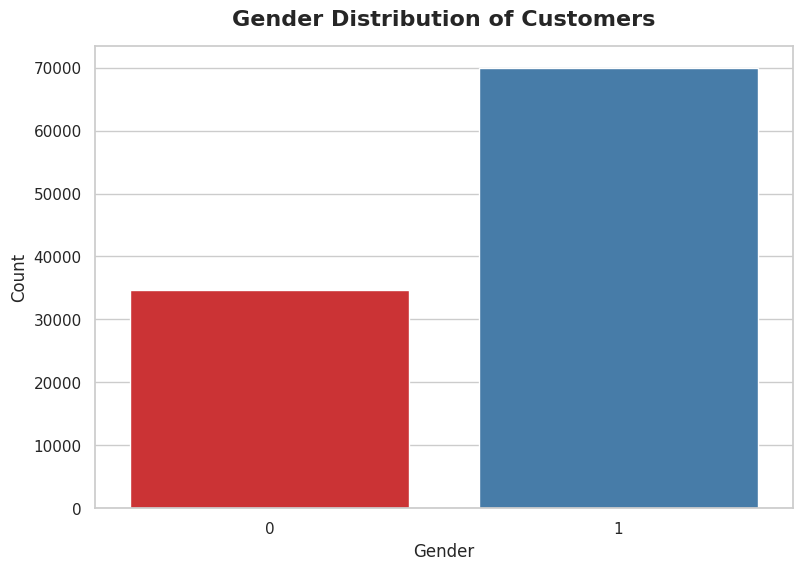

In [32]:
# Gender Distribution
plt.figure(figsize=(9,6))
sns.countplot(x='gender', data=final_test_df, hue='gender', palette='Set1', legend=False)
plt.title("Gender Distribution of Customers",fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

### **Gender Distribution**

- The test dataset includes ~105K customers, with gender encoded as 0 (male) and 1 (female).

- The chart shows a higher count of female-encoded customers, similar to the training dataset.

- This distribution helps the model understand demographic patterns and ensures gender is consistently processed across training and test sets.

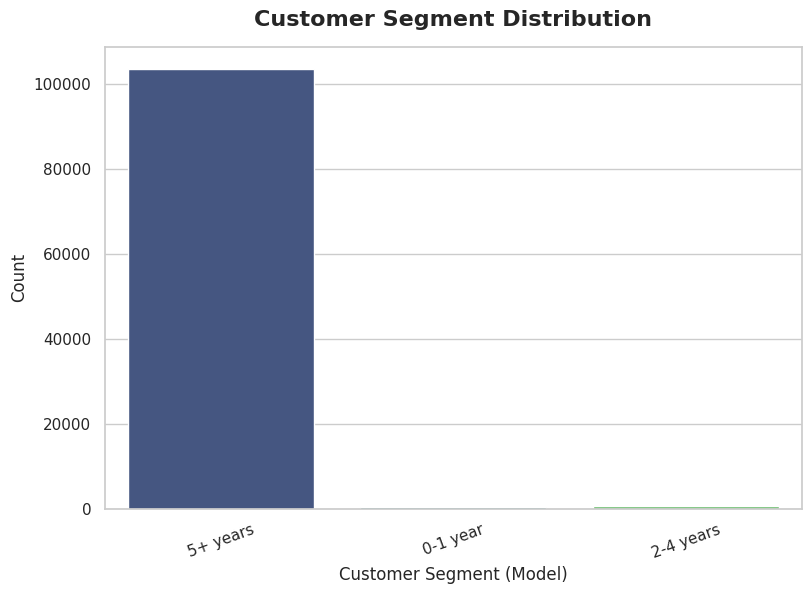

In [33]:
# Customer Segment Distribution
plt.figure(figsize=(9,6))
sns.countplot(
    x='customer_segment_model',
    data=final_test_df,
    hue='customer_segment_model',
    palette='viridis',
    legend=False
)
plt.title("Customer Segment Distribution", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Customer Segment (Model)")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.show()

### **Customer Segment Distribution**

- Segmentation was replicated using the same tenure-based rules as the training dataset.

- The majority of customers fall in the 5+ years segment, indicating a predominantly long-standing customer population.

- Very small proportions appear in the 0–1 year and 2–4 year categories, reinforcing that most test customers are mature accounts.

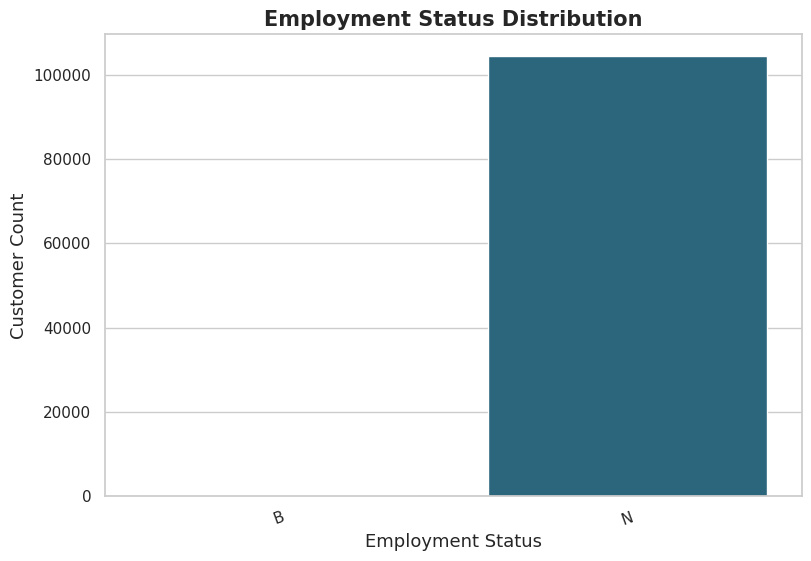

In [34]:
# Employment Status Distribution
plt.figure(figsize=(9,6))
sns.countplot(
    data=final_test_df,
    x='employment_status',
    palette='crest',
    hue='employment_status',
    legend=False
)
plt.title("Employment Status Distribution", fontsize=15, fontweight='bold')
plt.xlabel("Employment Status", fontsize=13)
plt.ylabel("Customer Count", fontsize=13)
plt.xticks(rotation=20)
plt.show()


### **Employment Status Distribution**

- Employment status is standardized to match the training schema.

- Most customers appear under the “N” (not employed) category, which reflects how Santander originally labels missing or non-specified employment codes.

- Only a very small percentage fall under “B” (ex-bank employee).

- This ensures employment status is interpreted uniformly between training and test datasets.

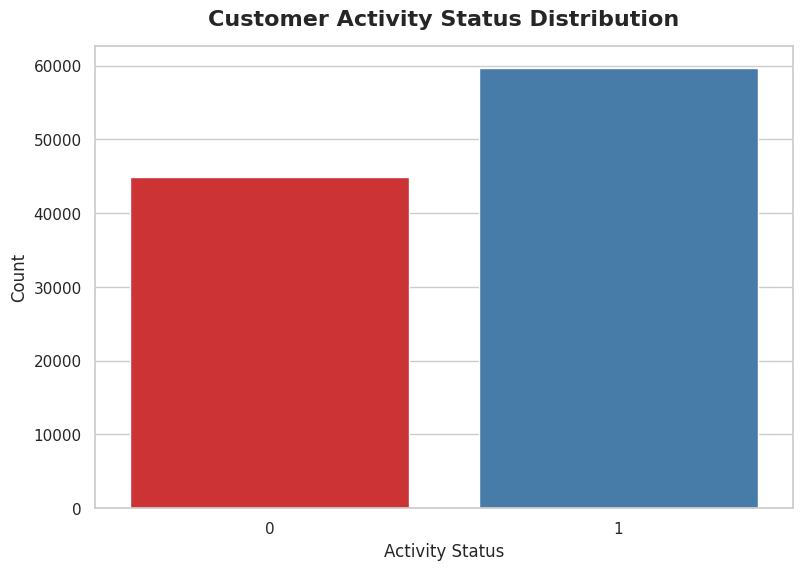

In [35]:
plt.figure(figsize=(9,6))
sns.countplot(
    x='activity_status',
    data=final_test_df,
    hue='activity_status',
    palette='Set1',
    legend=False
)
plt.title("Customer Activity Status Distribution", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Activity Status")
plt.ylabel("Count")
plt.show()

### **Customer Activity Status Distribution**

- Activity status identifies if a customer is active (1) or inactive (0).

- The distribution is split with a slight majority being active customers.

- This helps the model maintain consistency in understanding customer engagement levels, even though test data has no transaction records.

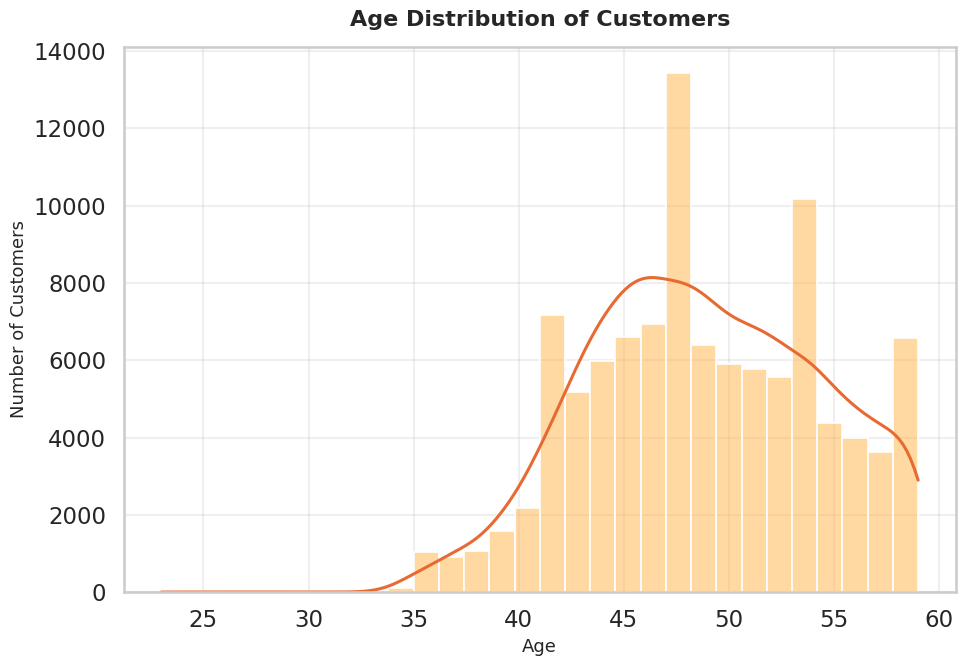

In [36]:
# Age Distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Clean, professional theme
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(10,7))

# Improved histogram with smoothed KDE (correct syntax for Seaborn ≥0.13)
sns.histplot(
    data=final_test_df,
    x='age',
    bins=30,
    color='#FFB347',          # soft amber-orange bars
    edgecolor='white',
    linewidth=1.2,
    kde=True,
    kde_kws={'bw_adjust': 1.5}  # smooths the trend line
)

# Style the KDE line manually using matplotlib after plotting
ax = plt.gca()
for line in ax.lines:  # find KDE line in the Axes
    line.set_color('#E86A33')
    line.set_linewidth(2.2)

# Titles and labels
plt.title("Age Distribution of Customers", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Age", fontsize=13)
plt.ylabel("Number of Customers", fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



### **Age Distribution**

- Customer ages follow a normal-like distribution centered around 45–55 years.

- There are fewer young customers (below 30) and older customers (over 60).

- This distribution mirrors typical banking demographics and supports consistent age scaling when applying models trained on the same patterns.

In [37]:
final_test_df.head(500)

,transaction_date,customer_id,employment_status,residence_country,gender,age,first_join_date,residence_index,channel_entrance,activity_status,household_gross_income,employment_status_int,personal_income,customer_tenure_months,customer_segment_model,years_calc
9,2016-06-28,15899,B,ES,1,57,2000-01-16,Y,KAT,1,130835.64,0,114958.79,200.266667,5+ years,20
10,2016-06-28,15900,B,ES,1,49,2000-01-16,Y,KAT,1,105327.03,0,61105.35,200.266667,5+ years,20
12,2016-06-28,15902,B,ES,0,58,2000-01-16,Y,KAT,1,230408.25,0,146092.52,200.266667,5+ years,20
14,2016-06-28,15906,N,ES,0,56,2006-02-16,Y,KAT,1,81005.49,1,65319.33,126.166667,5+ years,14
17,2016-06-28,15910,B,ES,1,54,2000-01-16,Y,KAT,0,77912.91,0,73201.69,200.266667,5+ years,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,2016-06-28,17733,N,ES,1,55,2000-05-15,Y,KAT,0,263225.49,1,219496.13,196.266667,5+ years,20
1017,2016-06-28,17734,N,ES,0,55,2011-03-24,Y,KAT,0,263225.49,1,245648.79,64.100000,5+ years,9
1018,2016-06-28,17735,N,ES,1,47,2005-03-08,Y,KAT,1,202828.71,1,129368.74,137.666667,5+ years,15
1019,2016-06-28,17736,N,ES,0,57,2009-01-19,Y,KAT,1,320411.97,1,302989.94,90.566667,5+ years,11


In [38]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
import os

drive.mount('/content/drive')

# Create the directory structure if it doesn't exist
import os

# Define the full path (based on your Drive structure)
save_path = '/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/project_dataset/'


# Create directories if they don't exist
os.makedirs(save_path, exist_ok=True)
print(f"✓ Directory created/verified: {save_path}")

# Save the DataFrame
final_test_df.to_parquet(save_path + 'customer_test.parquet', index=True)
print(f"✓ File saved successfully to: {save_path}customer_test.parquet")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Directory created/verified: /content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/project_dataset/
✓ File saved successfully to: /content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/project_dataset/customer_test.parquet
